# Predictive Maintenance with Specialized GANs for Failure-Specific Oversampling

## Thesis Objective
This notebook is a core component of a thesis investigating advanced methods for handling class imbalance in predictive maintenance. The primary objective is to evaluate a specialized multi-GAN architecture against traditional sampling techniques. Instead of a single generative model for all failures, we train multiple Generative Adversarial Networks (GANs), where each GAN is an expert on a specific failure type (e.g., Overstrain, Power Failure). This approach is hypothesized to generate more realistic and useful synthetic data by capturing the unique data signatures of each failure mode.

We will compare the performance of Random Forest and SVM classifiers trained on data augmented by this specialized GAN approach against a baseline and standard methods like SMOTE and Random Undersampling.

## Notebook Structure
1.  Setup: Import libraries and provide environment setup guidance.
2.  GPU Check: Verify GPU availability for PyTorch, which accelerates TabGAN training.
3.  Load & Preprocess Data: Load, clean, and perform feature engineering on the predictive_maintenance.csv dataset.
4.  Exploratory Data Analysis (EDA): Analyze data characteristics, with a focus on the distinct signatures of different failure types.
5.  Data Splitting: Split data into Train, Validation, and Test sets to ensure robust evaluation and prevent data leakage.
6.  Modeling Scenarios:
    *   Scenario 1: Baseline (No Resampling)
    *   Scenario 2: Random Undersampling
    *   Scenario 3: SMOTE Oversampling
    *   Scenario 4: Specialized Multi-GAN Oversampling - This is the core of the new approach.
7.  Hyperparameter Tuning & Model Training:
    *   For the Multi-GAN scenario, a hyperparameter search is conducted to find the optimal GAN parameters, evaluating against the validation set.
    *   For all scenarios, GridSearchCV is used to tune the final classifiers (Random Forest & SVM).
8.  Evaluation: Assess all final models on the unseen test set using metrics appropriate for imbalanced data (F1, ROC-AUC, Recall, Precision).
9.  Results Comparison: Compile and visualize results to compare the effectiveness of each sampling strategy.
10. Conclusion: Discuss the findings, focusing on the performance of the specialized multi-GAN architecture.

## 1. Setup

This section imports necessary libraries and provides instructions for setting up the Python environment, including optional GPU acceleration via CUDA for TabGAN.

In [1]:
# Core Libraries
import pandas as pd
import numpy as np
import warnings
import time # To measure execution time
import logging # To manage library logging

# Scikit-learn
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, ParameterGrid
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    RocCurveDisplay
)

# Imbalanced-learn
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
# Pipeline compatible with imblearn transformers
from imblearn.pipeline import Pipeline as ImbPipeline

# TabGAN (for GAN Oversampling)
try:
    from tabgan.sampler import GANGenerator
    import torch # TabGAN uses PyTorch
    GAN_AVAILABLE = True
    PYTORCH_AVAILABLE = True
except ImportError as e:
    print(f"Warning: TabGAN or PyTorch could not be imported. GAN scenario will be skipped. Error: {e}")
    print("Try installing with: pip install tabgan torch torchvision torchaudio")
    GANGenerator = None # Define as None if import fails
    GAN_AVAILABLE = False
    PYTORCH_AVAILABLE = False


# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Notebook Configuration
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
sns.set(style="whitegrid")

print("Libraries imported.")
if PYTORCH_AVAILABLE:
    print(f"PyTorch Version: {torch.__version__}")
if GAN_AVAILABLE:
    print("TabGAN (for GAN Oversampling) is available.")
else:
    print("TabGAN could not be loaded. GAN scenario will be skipped.")

Libraries imported.
PyTorch Version: 2.5.1
TabGAN (for GAN Oversampling) is available.


## 2. GPU Check

This cell checks if a CUDA-enabled GPU is available for PyTorch (used by TabGAN).

In [2]:
gpu_available_for_tabgan = False
if PYTORCH_AVAILABLE:
    if torch.cuda.is_available():
        print(f"SUCCESS: PyTorch detected CUDA-enabled GPU: {torch.cuda.get_device_name(0)}")
        print("TabGAN will attempt to use the GPU if available.")
        gpu_available_for_tabgan = True
    else:
        print("INFO: PyTorch did not detect a CUDA-enabled GPU. TabGAN will run on CPU.")
else:
    print("INFO: PyTorch not available, cannot check for GPU for TabGAN.")

SUCCESS: PyTorch detected CUDA-enabled GPU: NVIDIA GeForce GTX 1060 with Max-Q Design
TabGAN will attempt to use the GPU if available.


## 3. Load & Preprocess Data

Load the dataset, perform feature engineering by converting temperature units and creating a difference feature, and sanitize column names.

In [3]:
# Load the dataset
try:
    df = pd.read_csv('predictive_maintenance.csv')
    print("Dataset loaded successfully.")
    print(f"Original dataset shape: {df.shape}")
except FileNotFoundError:
    print("Error: predictive_maintenance.csv not found. Please ensure the file is in the same directory as the notebook.")
    df = None

if df is not None:
    # Drop unnecessary columns
    df = df.drop(['UDI', 'Product ID'], axis=1)

    # ### NEW: Feature Engineering from Kaggle Notebook ###
    # 1. Convert temperatures from Kelvin to Celsius for better interpretability
    df['Air temperature [K]'] = df['Air temperature [K]'] - 273.15
    df['Process temperature [K]'] = df['Process temperature [K]'] - 273.15
    df.rename(columns={'Air temperature [K]': 'Air_temperature_C', 'Process temperature [K]': 'Process_temperature_C'}, inplace=True)
    print("\nConverted temperature units from Kelvin to Celsius.")

    # 2. Create the temperature difference feature
    df['Temperature_difference_C'] = df['Process_temperature_C'] - df['Air_temperature_C']
    print("Created 'Temperature_difference_C' feature.")

    # --- Data Cleaning: Sanitize All Column Names ---
    print("\nOriginal column names:\n", df.columns.tolist())
    clean_cols = {col: col.replace('[', '').replace(']', '').replace(' ', '').replace('(', '').replace(')', '') for col in df.columns}
    df.rename(columns=clean_cols, inplace=True)
    print("\nCleaned column names:\n", df.columns.tolist())

    # --- IMPORTANT: Update feature lists with new and cleaned names ---
    numerical_features = ['Air_temperature_C', 'Process_temperature_C', 'Rotationalspeedrpm', 'TorqueNm', 'Toolwearmin', 'Temperature_difference_C']
    categorical_features = ['Type']
    print("\nUpdated feature lists defined.")

    print("\nFirst 5 rows of the preprocessed dataset:")
    display(df.head())

    print("\nDataset Information after preprocessing:")
    df.info()

    print("\nDescriptive Statistics after preprocessing:")
    display(df.describe())

Dataset loaded successfully.
Original dataset shape: (10000, 10)

Converted temperature units from Kelvin to Celsius.
Created 'Temperature_difference_C' feature.

Original column names:
 ['Type', 'Air_temperature_C', 'Process_temperature_C', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]', 'Target', 'Failure Type', 'Temperature_difference_C']

Cleaned column names:
 ['Type', 'Air_temperature_C', 'Process_temperature_C', 'Rotationalspeedrpm', 'TorqueNm', 'Toolwearmin', 'Target', 'FailureType', 'Temperature_difference_C']

Updated feature lists defined.

First 5 rows of the preprocessed dataset:


,Type,Air_temperature_C,Process_temperature_C,Rotationalspeedrpm,TorqueNm,Toolwearmin,Target,FailureType,Temperature_difference_C
0,M,24.95,35.45,1551,42.8,0,0,No Failure,10.5
1,L,25.05,35.55,1408,46.3,3,0,No Failure,10.5
2,L,24.95,35.35,1498,49.4,5,0,No Failure,10.4
3,L,25.05,35.45,1433,39.5,7,0,No Failure,10.4
4,L,25.05,35.55,1408,40.0,9,0,No Failure,10.5



Dataset Information after preprocessing:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Type                      10000 non-null  object 
 1   Air_temperature_C         10000 non-null  float64
 2   Process_temperature_C     10000 non-null  float64
 3   Rotationalspeedrpm        10000 non-null  int64  
 4   TorqueNm                  10000 non-null  float64
 5   Toolwearmin               10000 non-null  int64  
 6   Target                    10000 non-null  int64  
 7   FailureType               10000 non-null  object 
 8   Temperature_difference_C  10000 non-null  float64
dtypes: float64(4), int64(3), object(2)
memory usage: 703.2+ KB

Descriptive Statistics after preprocessing:


,Air_temperature_C,Process_temperature_C,Rotationalspeedrpm,TorqueNm,Toolwearmin,Target,Temperature_difference_C
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,26.854930,36.855560,1538.776100,39.986910,107.951000,0.033900,10.000630
std,2.000259,1.483734,179.284096,9.968934,63.654147,0.180981,1.001094
min,22.150000,32.550000,1168.000000,3.800000,0.000000,0.000000,7.600000
25%,25.150000,35.650000,1423.000000,33.200000,53.000000,0.000000,9.300000
50%,26.950000,36.950000,1503.000000,40.100000,108.000000,0.000000,9.800000
75%,28.350000,37.950000,1612.000000,46.800000,162.000000,0.000000,11.000000
max,31.350000,40.650000,2886.000000,76.600000,253.000000,1.000000,12.100000


## 4. Exploratory Data Analysis (EDA)

Analyze data characteristics, distributions, correlations, and the nature of the class imbalance.

### 4.1 Target Variable & Failure Type Analysis

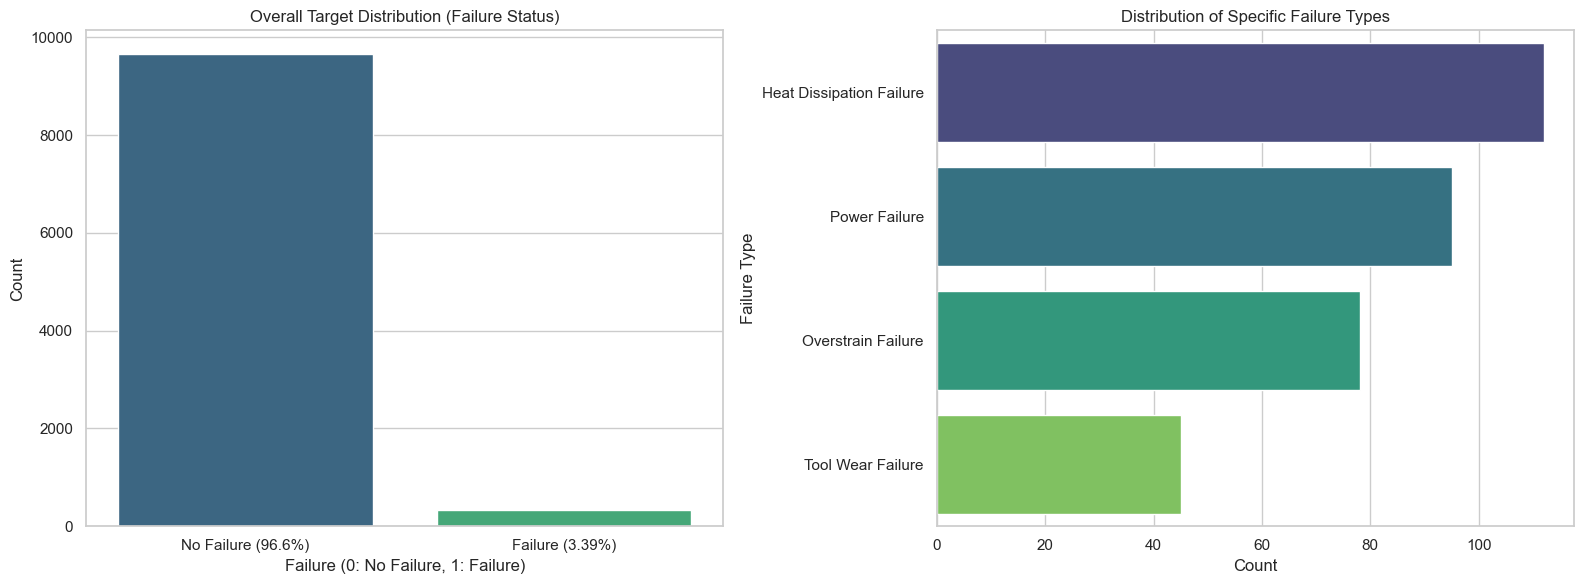

Failure Type Counts:
FailureType
Heat Dissipation Failure    112
Power Failure                95
Overstrain Failure           78
Tool Wear Failure            45
Name: count, dtype: int64


In [4]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Overall Target Distribution
target_counts = df['Target'].value_counts()
sns.countplot(x='Target', data=df, palette='viridis', ax=axes[0])
axes[0].set_title('Overall Target Distribution (Failure Status)')
axes[0].set_xlabel('Failure (0: No Failure, 1: Failure)')
axes[0].set_ylabel('Count')
axes[0].set_xticks([0, 1], ['No Failure (96.6%)', f'Failure ({target_counts[1]/len(df):.2%})'])

# Plot 2: Specific Failure Type Distribution
failure_df = df[df['Target'] == 1]
# Use the cleaned column name 'FailureType'
failure_type_counts = failure_df['FailureType'].value_counts()
failure_type_counts = failure_type_counts[failure_type_counts.index != 'No Failure']
# Use the cleaned column name 'FailureType' for the y-axis
sns.countplot(y='FailureType', data=failure_df[failure_df['FailureType'] != 'No Failure'], order=failure_type_counts.index, palette='viridis', ax=axes[1])
axes[1].set_title('Distribution of Specific Failure Types')
axes[1].set_xlabel('Count')
axes[1].set_ylabel('Failure Type')

plt.tight_layout()
plt.show()

print("Failure Type Counts:")
print(failure_type_counts)

### 4.2 Feature Distributions and Relationships

Numerical Feature Distributions by Failure Status:


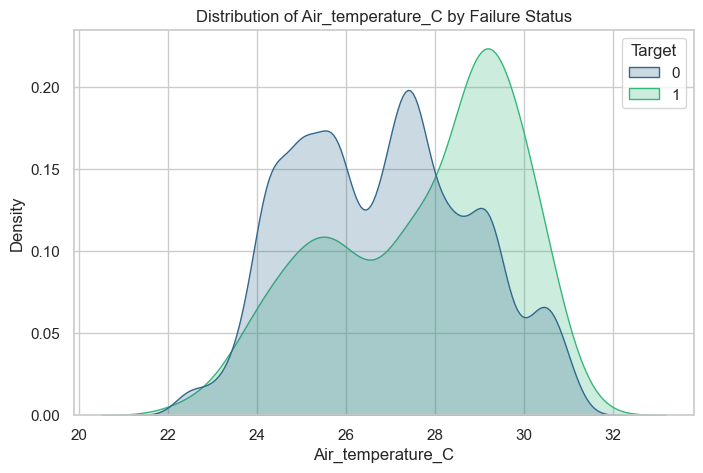

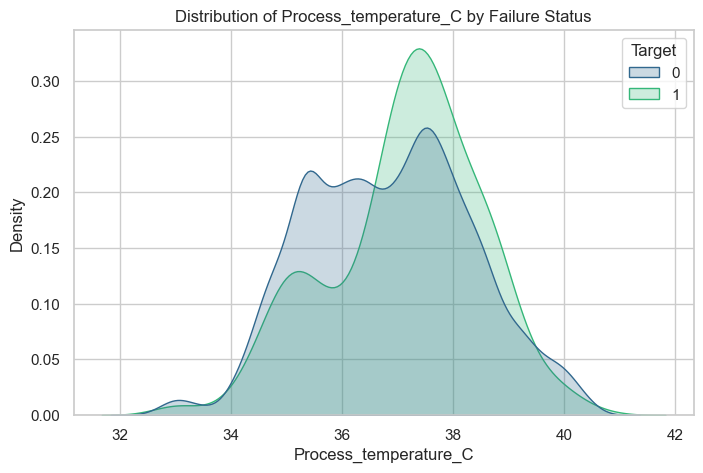

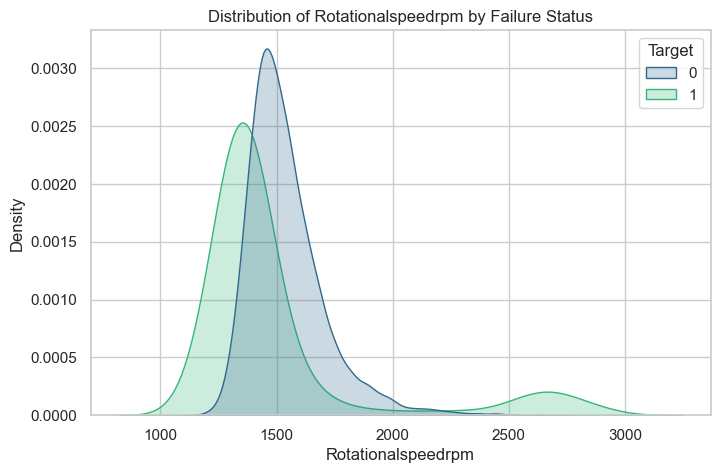

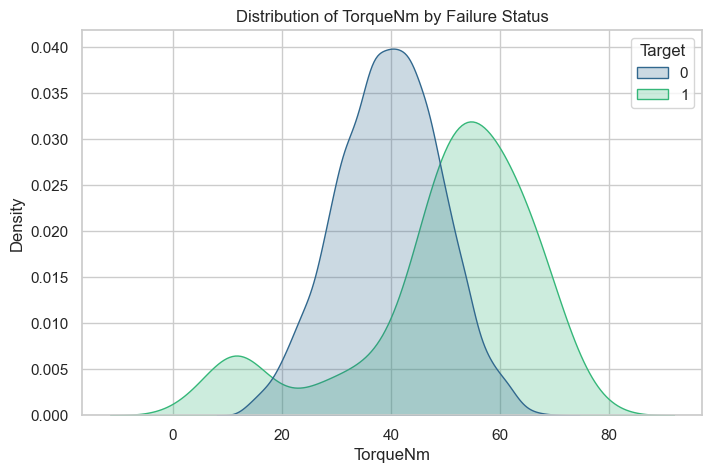

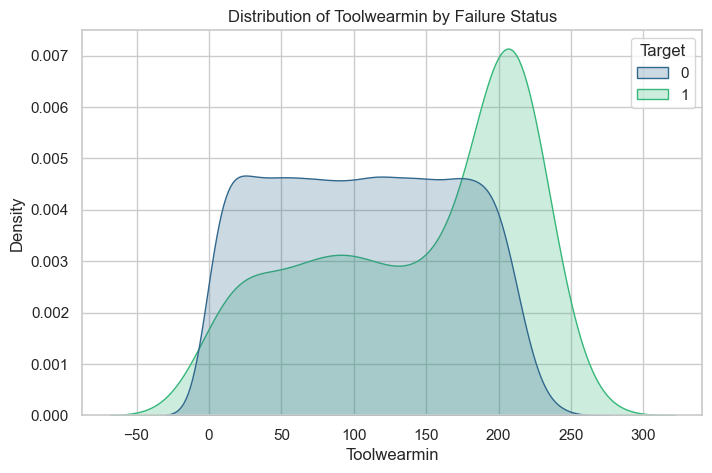

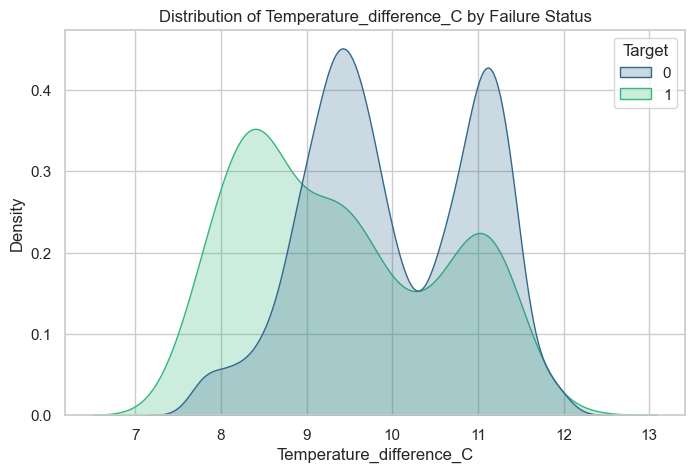

In [5]:
# Plot distributions grouped by Target variable
print("Numerical Feature Distributions by Failure Status:")
for col in numerical_features:
    plt.figure(figsize=(8, 5))
    sns.kdeplot(data=df, x=col, hue='Target', fill=True, common_norm=False, palette='viridis')
    plt.title(f'Distribution of {col} by Failure Status')
    handles, labels = plt.gca().get_legend_handles_labels()
    if len(handles) == 2:
        plt.legend(handles, ['No Failure (0)', 'Failure (1)'], title='Failure Status')
    plt.show()

### 4.3 Correlation Analysis

Correlation Matrix:


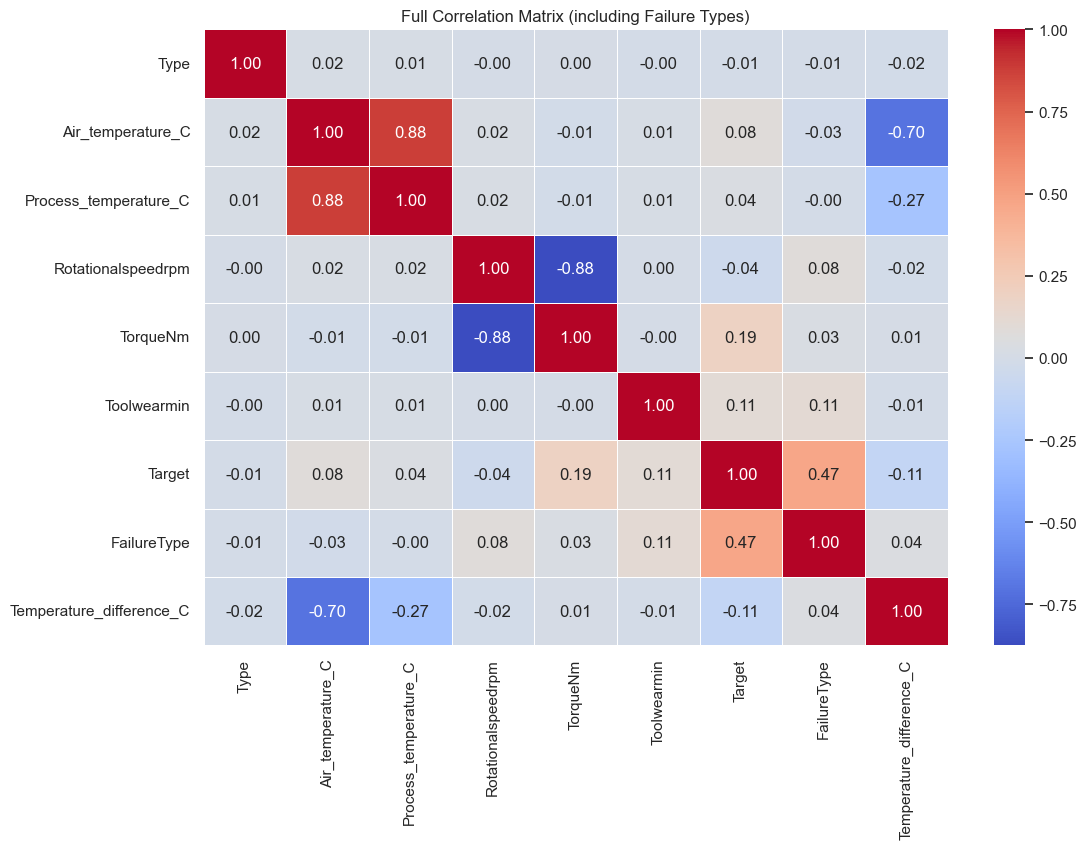

In [6]:
# Create a copy for correlation analysis
df_corr = df.copy()

# Convert categorical columns to numeric codes for correlation
df_corr['Type'] = df_corr['Type'].astype('category').cat.codes
# Use the cleaned column name 'FailureType'
df_corr['FailureType'] = df_corr['FailureType'].astype('category').cat.codes

print("Correlation Matrix:")
correlation_matrix = df_corr.corr() 

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Full Correlation Matrix (including Failure Types)')
plt.show()

## 5. Data Splitting & Final Preprocessing Setup

We will define the ColumnTransformer for consistent scaling and encoding. Crucially, we split the data into Training (70%), Validation (15%), and Test (15%) sets. The validation set is essential for tuning the GAN hyperparameters without leaking information from the final test set.

In [7]:
# Define features (X) and target (y)
# We keep 'Failure_Type' in X for now to identify subsets for GAN training
X = df.drop(['Target'], axis=1)
y = df['Target']

# --- Train-Validation-Test Split ---
# First split: 70% for training, 30% for a temporary set (validation + test)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Second split: Split the 30% temp set into 15% validation and 15% test (50/50 split)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print("--- Data Split Complete ---")
print(f"Training set shape: {X_train.shape}, Target distribution:\n{y_train.value_counts(normalize=True)}\n")
print(f"Validation set shape: {X_val.shape}, Target distribution:\n{y_val.value_counts(normalize=True)}\n")
print(f"Test set shape: {X_test.shape}, Target distribution:\n{y_test.value_counts(normalize=True)}\n")

# Now we can drop 'FailureType' from the feature sets used for classification
X_train_model = X_train.drop('FailureType', axis=1)
X_val_model = X_val.drop('FailureType', axis=1)
X_test_model = X_test.drop('FailureType', axis=1)

# Define the preprocessor using the final feature lists
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', drop='first'), categorical_features)
    ],
    remainder='passthrough'
)

print("Preprocessor (ColumnTransformer) configured.")

--- Data Split Complete ---
Training set shape: (7000, 8), Target distribution:
Target
0    0.966143
1    0.033857
Name: proportion, dtype: float64

Validation set shape: (1500, 8), Target distribution:
Target
0    0.966
1    0.034
Name: proportion, dtype: float64

Test set shape: (1500, 8), Target distribution:
Target
0    0.966
1    0.034
Name: proportion, dtype: float64

Preprocessor (ColumnTransformer) configured.


## 6. Modeling Setup

Define models, hyperparameter grids, metrics, and the cross-validation strategy.

In [8]:
# Define Models
rf_model = RandomForestClassifier(random_state=42, class_weight='balanced', n_jobs=-1)
svm_model = SVC(random_state=42, probability=True, class_weight='balanced', cache_size=500)

# Define Hyperparameter Grids for final classifiers
param_grid_rf = {
    'model__n_estimators': [100, 200],
    'model__max_depth': [10, 20],
    'model__min_samples_leaf': [1, 3]
}

param_grid_svm = {
    'model__C': [1, 10],
    'model__gamma': ['scale', 0.1]
}

# Store results and best model info
results = {}
best_models_info = {}

# Define Stratified K-Fold for cross-validation
cv_stratified = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

print("Models, hyperparameter grids, and evaluation setup complete.")

Models, hyperparameter grids, and evaluation setup complete.


In [9]:
# Define the evaluation helper function
def evaluate_model(model_name, scenario_name, model, X_test_eval, y_test_eval, results_dict):
    """Calculates and stores evaluation metrics for a given model and test set."""
    print(f"--- Evaluating {model_name} ({scenario_name}) ---")
    start_time = time.time()
    y_pred = model.predict(X_test_eval)
    y_prob = model.predict_proba(X_test_eval)[:, 1]
    end_time = time.time()
    inference_time = end_time - start_time

    metrics = {
        'Accuracy': accuracy_score(y_test_eval, y_pred),
        'Precision': precision_score(y_test_eval, y_pred, zero_division=0),
        'Recall': recall_score(y_test_eval, y_pred),
        'F1': f1_score(y_test_eval, y_pred),
        'ROC_AUC': roc_auc_score(y_test_eval, y_prob)
    }

    if scenario_name not in results_dict:
        results_dict[scenario_name] = {}
    results_dict[scenario_name][model_name] = metrics

    print(f"Inference Time: {inference_time:.2f} seconds")
    print(classification_report(y_test_eval, y_pred, zero_division=0))
    print(f"ROC AUC Score: {metrics['ROC_AUC']:.4f}")
    print("-" * 60)

    # Plot Confusion Matrix and ROC Curve side-by-side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    fig.suptitle(f'Evaluation for {model_name} ({scenario_name})', fontsize=16)
    
    # Confusion Matrix
    cm = confusion_matrix(y_test_eval, y_pred)
    ConfusionMatrixDisplay(confusion_matrix=cm).plot(cmap=plt.cm.Blues, ax=ax1)
    ax1.set_title('Confusion Matrix')
    
    # ROC Curve
    RocCurveDisplay.from_predictions(y_test_eval, y_prob, ax=ax2, name=model_name)
    ax2.plot([0, 1], [0, 1], 'k--', label='Chance level (AUC = 0.5)')
    ax2.set_title('ROC Curve')
    ax2.legend()
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

    return metrics

## 7. Modeling Scenarios

We will now implement the four scenarios. Note: Resampling techniques are always applied only to the training data to prevent data leakage.

### Scenario 1: Baseline (No Resampling)

--- Scenario 1: Baseline (No Resampling) ---

Training Random Forest (Baseline)...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
--- Evaluating Random Forest (Baseline) ---
Inference Time: 0.16 seconds
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1449
           1       0.86      0.71      0.77        51

    accuracy                           0.99      1500
   macro avg       0.92      0.85      0.88      1500
weighted avg       0.99      0.99      0.99      1500

ROC AUC Score: 0.9803
------------------------------------------------------------


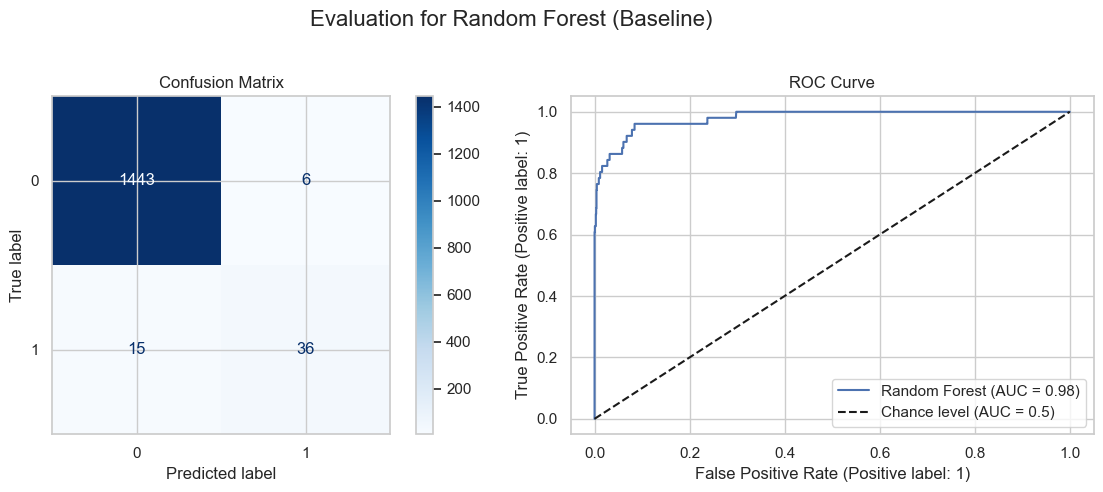


Training SVM (Baseline)...
Fitting 5 folds for each of 4 candidates, totalling 20 fits
--- Evaluating SVM (Baseline) ---
Inference Time: 0.67 seconds
              precision    recall  f1-score   support

           0       1.00      0.91      0.95      1449
           1       0.27      0.92      0.42        51

    accuracy                           0.91      1500
   macro avg       0.63      0.92      0.69      1500
weighted avg       0.97      0.91      0.94      1500

ROC AUC Score: 0.9729
------------------------------------------------------------


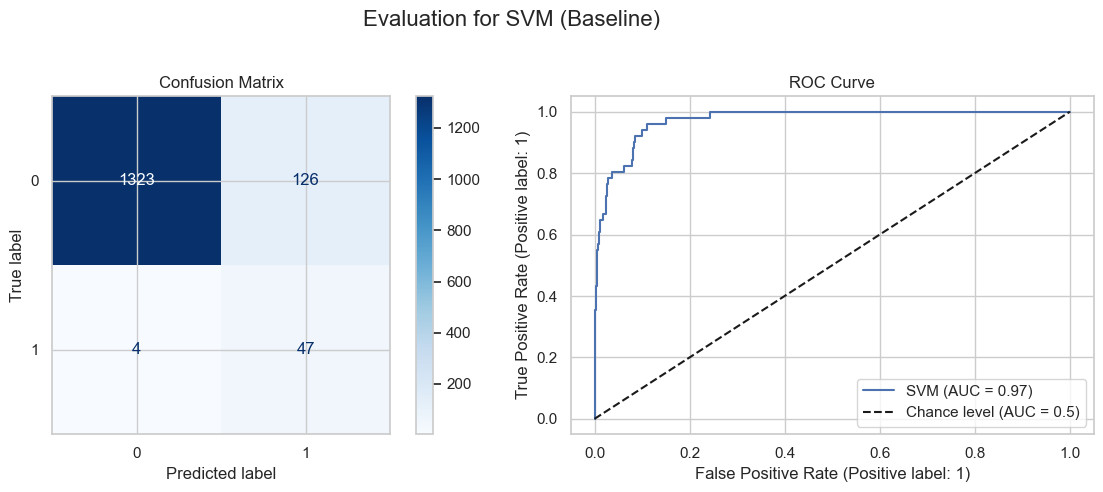

{'Accuracy': 0.9133333333333333,
 'Precision': 0.27167630057803466,
 'Recall': 0.9215686274509803,
 'F1': 0.4196428571428571,
 'ROC_AUC': 0.9728683744029012}

In [10]:
print("--- Scenario 1: Baseline (No Resampling) ---")
scenario = 'Baseline'
best_models_info[scenario] = {}

# --- Random Forest ---
model_name_rf = 'Random Forest'
print(f"\nTraining {model_name_rf} ({scenario})...")
pipeline_rf_base = Pipeline([('preprocessor', preprocessor), ('model', rf_model)])
grid_search_rf_base = GridSearchCV(pipeline_rf_base, param_grid_rf, cv=cv_stratified, scoring='roc_auc', n_jobs=-1, verbose=1)
grid_search_rf_base.fit(X_train_model, y_train)
best_models_info[scenario][model_name_rf] = {'model': grid_search_rf_base.best_estimator_}
evaluate_model(model_name_rf, scenario, grid_search_rf_base.best_estimator_, X_test_model, y_test, results)

# --- SVM ---
model_name_svm = 'SVM'
print(f"\nTraining {model_name_svm} ({scenario})...")
pipeline_svm_base = Pipeline([('preprocessor', preprocessor), ('model', svm_model)])
grid_search_svm_base = GridSearchCV(pipeline_svm_base, param_grid_svm, cv=cv_stratified, scoring='roc_auc', n_jobs=-1, verbose=1)
grid_search_svm_base.fit(X_train_model, y_train)
best_models_info[scenario][model_name_svm] = {'model': grid_search_svm_base.best_estimator_}
evaluate_model(model_name_svm, scenario, grid_search_svm_base.best_estimator_, X_test_model, y_test, results)

### Scenario 2: Random Undersampling (RUS)


--- Scenario 2: Random Undersampling (RUS) ---

Training Random Forest (Random Undersampling)...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
--- Evaluating Random Forest (Random Undersampling) ---
Inference Time: 0.22 seconds
              precision    recall  f1-score   support

           0       1.00      0.89      0.94      1449
           1       0.23      0.92      0.36        51

    accuracy                           0.89      1500
   macro avg       0.61      0.91      0.65      1500
weighted avg       0.97      0.89      0.92      1500

ROC AUC Score: 0.9662
------------------------------------------------------------


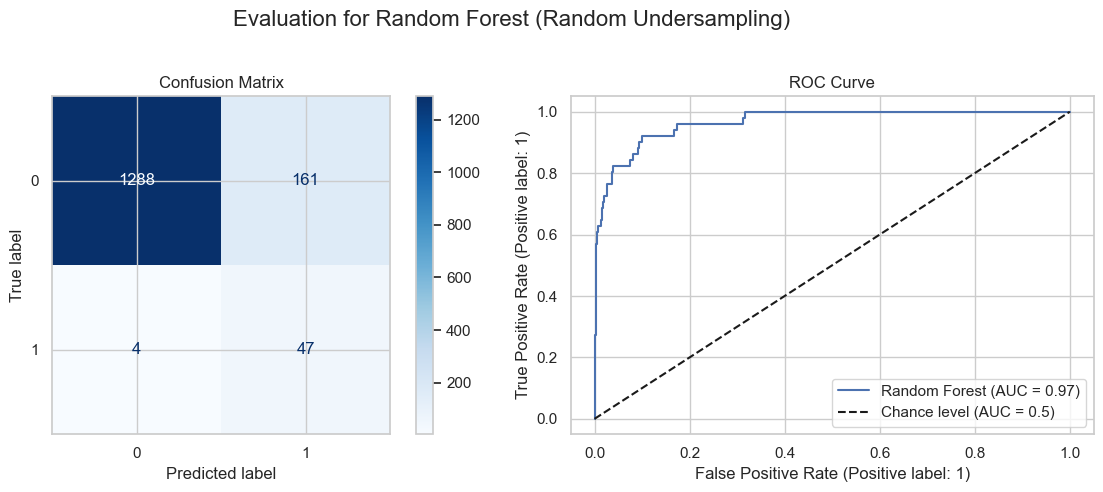


Training SVM (Random Undersampling)...
Fitting 5 folds for each of 4 candidates, totalling 20 fits
--- Evaluating SVM (Random Undersampling) ---
Inference Time: 0.08 seconds
              precision    recall  f1-score   support

           0       1.00      0.89      0.94      1449
           1       0.22      0.88      0.36        51

    accuracy                           0.89      1500
   macro avg       0.61      0.89      0.65      1500
weighted avg       0.97      0.89      0.92      1500

ROC AUC Score: 0.9593
------------------------------------------------------------


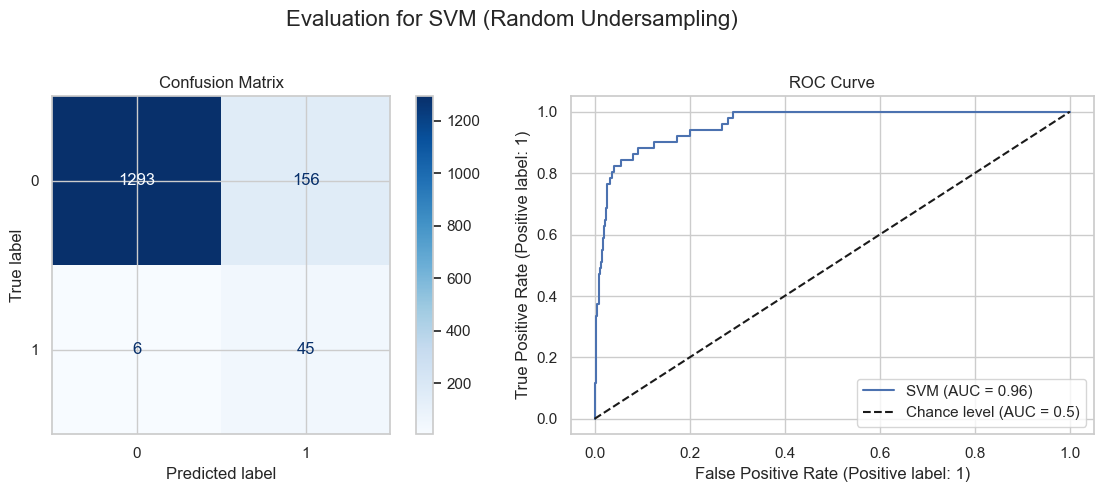

{'Accuracy': 0.892,
 'Precision': 0.22388059701492538,
 'Recall': 0.8823529411764706,
 'F1': 0.35714285714285715,
 'ROC_AUC': 0.9593228595786141}

In [11]:
print("\n--- Scenario 2: Random Undersampling (RUS) ---")
scenario = 'Random Undersampling'
best_models_info[scenario] = {}
rus = RandomUnderSampler(sampling_strategy='auto', random_state=42)

# --- Random Forest with RUS ---
model_name_rf = 'Random Forest'
print(f"\nTraining {model_name_rf} ({scenario})...")
pipeline_rf_rus = ImbPipeline([('preprocessor', preprocessor), ('sampler', rus), ('model', rf_model)])
grid_search_rf_rus = GridSearchCV(pipeline_rf_rus, param_grid_rf, cv=cv_stratified, scoring='roc_auc', n_jobs=-1, verbose=1)
grid_search_rf_rus.fit(X_train_model, y_train)
best_models_info[scenario][model_name_rf] = {'model': grid_search_rf_rus.best_estimator_}
evaluate_model(model_name_rf, scenario, grid_search_rf_rus.best_estimator_, X_test_model, y_test, results)

# --- SVM with RUS ---
model_name_svm = 'SVM'
print(f"\nTraining {model_name_svm} ({scenario})...")
pipeline_svm_rus = ImbPipeline([('preprocessor', preprocessor), ('sampler', rus), ('model', svm_model)])
grid_search_svm_rus = GridSearchCV(pipeline_svm_rus, param_grid_svm, cv=cv_stratified, scoring='roc_auc', n_jobs=-1, verbose=1)
grid_search_svm_rus.fit(X_train_model, y_train)
best_models_info[scenario][model_name_svm] = {'model': grid_search_svm_rus.best_estimator_}
evaluate_model(model_name_svm, scenario, grid_search_svm_rus.best_estimator_, X_test_model, y_test, results)

### Scenario 3: SMOTE Oversampling


--- Scenario 3: SMOTE Oversampling ---

Training Random Forest (SMOTE Oversampling)...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
--- Evaluating Random Forest (SMOTE Oversampling) ---
Inference Time: 0.37 seconds
              precision    recall  f1-score   support

           0       0.99      0.98      0.98      1449
           1       0.53      0.78      0.63        51

    accuracy                           0.97      1500
   macro avg       0.76      0.88      0.81      1500
weighted avg       0.98      0.97      0.97      1500

ROC AUC Score: 0.9749
------------------------------------------------------------


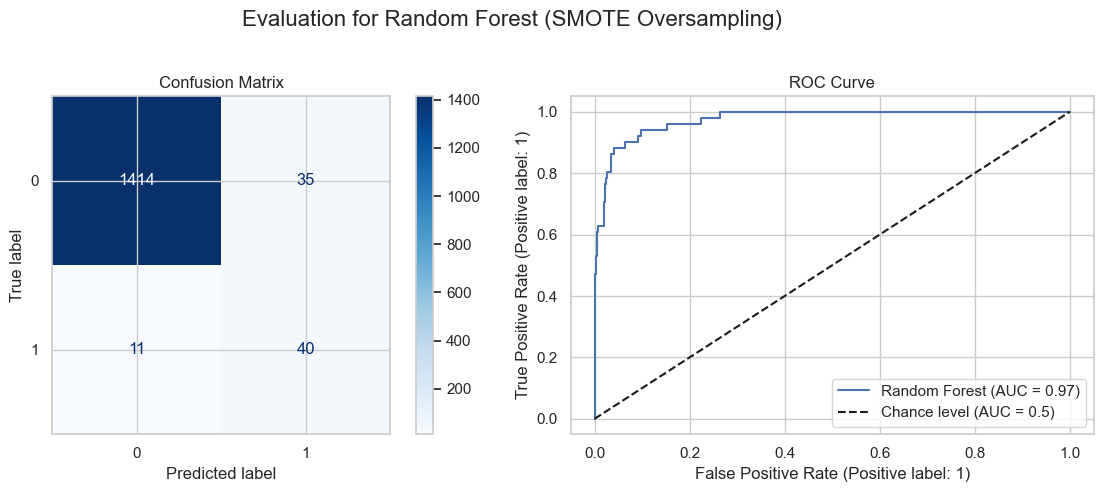


Training SVM (SMOTE Oversampling)...
Fitting 5 folds for each of 4 candidates, totalling 20 fits
--- Evaluating SVM (SMOTE Oversampling) ---
Inference Time: 1.08 seconds
              precision    recall  f1-score   support

           0       0.99      0.92      0.96      1449
           1       0.28      0.86      0.42        51

    accuracy                           0.92      1500
   macro avg       0.63      0.89      0.69      1500
weighted avg       0.97      0.92      0.94      1500

ROC AUC Score: 0.9721
------------------------------------------------------------


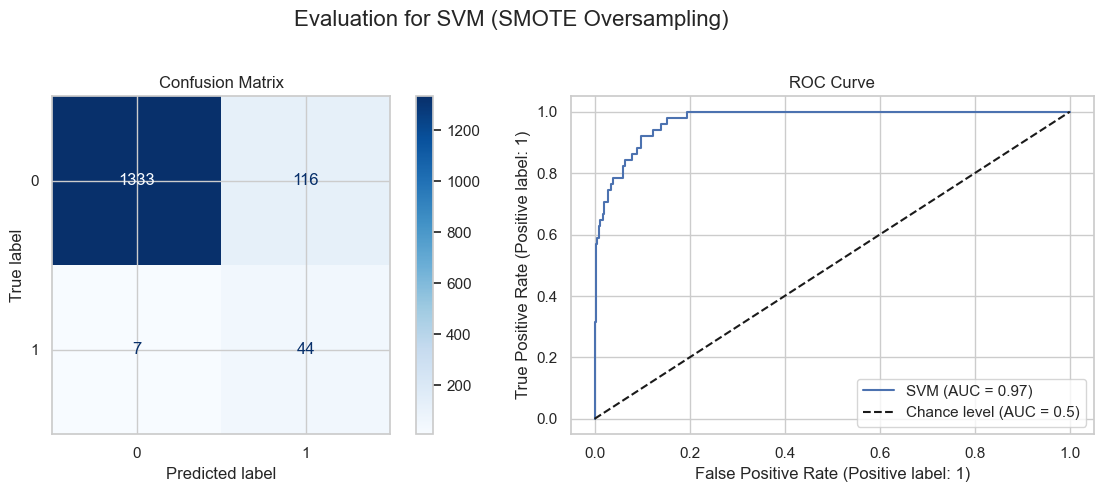

{'Accuracy': 0.918,
 'Precision': 0.275,
 'Recall': 0.8627450980392157,
 'F1': 0.4170616113744076,
 'ROC_AUC': 0.9721105833637803}

In [12]:
print("\n--- Scenario 3: SMOTE Oversampling ---")
scenario = 'SMOTE Oversampling'
best_models_info[scenario] = {}
smote = SMOTE(sampling_strategy='auto', random_state=42, k_neighbors=5, n_jobs=-1)

# --- Random Forest with SMOTE ---
model_name_rf = 'Random Forest'
print(f"\nTraining {model_name_rf} ({scenario})...")
pipeline_rf_smote = ImbPipeline([('preprocessor', preprocessor), ('sampler', smote), ('model', rf_model)])
grid_search_rf_smote = GridSearchCV(pipeline_rf_smote, param_grid_rf, cv=cv_stratified, scoring='roc_auc', n_jobs=-1, verbose=1)
grid_search_rf_smote.fit(X_train_model, y_train)
best_models_info[scenario][model_name_rf] = {'model': grid_search_rf_smote.best_estimator_}
evaluate_model(model_name_rf, scenario, grid_search_rf_smote.best_estimator_, X_test_model, y_test, results)

# --- SVM with SMOTE ---
model_name_svm = 'SVM'
print(f"\nTraining {model_name_svm} ({scenario})...")
pipeline_svm_smote = ImbPipeline([('preprocessor', preprocessor), ('sampler', smote), ('model', svm_model)])
grid_search_svm_smote = GridSearchCV(pipeline_svm_smote, param_grid_svm, cv=cv_stratified, scoring='roc_auc', n_jobs=-1, verbose=1)
grid_search_svm_smote.fit(X_train_model, y_train)
best_models_info[scenario][model_name_svm] = {'model': grid_search_svm_smote.best_estimator_}
evaluate_model(model_name_svm, scenario, grid_search_svm_smote.best_estimator_, X_test_model, y_test, results)

### Scenario 4: Specialized Multi-GAN Oversampling

This scenario implements the core hypothesis of the thesis. We train a separate GAN for each major failure type to learn its specific data signature. This involves a hyperparameter tuning loop to find the best GAN settings before training the final classifiers.

Process:
1.  Hyperparameter Search: A grid of GAN and adversarial model parameters is defined. The loop iterates through this grid.
2.  Specialized GAN Training (per parameter set): For each parameter combination, a separate GAN is trained on the data for each specific failure type (Heat Dissipation, Power, Overstrain, Tool Wear).
3.  Data Generation & Augmentation: Synthetic data is generated from each specialized GAN. This data is then combined with the original training set.
4.  Validation: A fast, non-tuned Random Forest model is trained on the augmented data and evaluated on the validation set. The GAN parameters that yield the highest ROC AUC on the validation set are considered the best.
5.  Final Model Training: Using the best GAN parameters found, a final, high-quality augmented dataset is generated. GridSearchCV is then used to train and tune the RF and SVM classifiers on this dataset.
6.  Final Evaluation: The performance of the final, tuned classifiers is measured on the unseen test set.


--- Scenario 4: Generalized Single-GAN Oversampling (TabGAN with Optuna) ---

--- Optuna Trial #0 ---
--> Testing Params: {'gen_lr': 0.0002640943045306488, 'discriminator_steps': 3, 'network_dim': 128, 'patience': 5650, 'batch_size': 750, 'adv_n_estimators': 400, 'adv_max_depth': 15, 'adv_learning_rate': 0.03288182713002388}


Fitting CTGAN transformers for each column:   0%|          | 0/8 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

--- Result for Trial #0: Validation ROC AUC = 0.9613 ---

--- Optuna Trial #1 ---
--> Testing Params: {'gen_lr': 0.0003759064641745899, 'discriminator_steps': 2, 'network_dim': 256, 'patience': 3900, 'batch_size': 750, 'adv_n_estimators': 500, 'adv_max_depth': 19, 'adv_learning_rate': 0.05779021516403627}


Fitting CTGAN transformers for each column:   0%|          | 0/8 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

--- Result for Trial #1: Validation ROC AUC = 0.9574 ---

--- Optuna Trial #2 ---
--> Testing Params: {'gen_lr': 8.885254387427282e-05, 'discriminator_steps': 3, 'network_dim': 128, 'patience': 3900, 'batch_size': 750, 'adv_n_estimators': 200, 'adv_max_depth': 20, 'adv_learning_rate': 0.010638816948404446}


Fitting CTGAN transformers for each column:   0%|          | 0/8 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

--- Result for Trial #2: Validation ROC AUC = 0.9590 ---

--- Optuna Trial #3 ---
--> Testing Params: {'gen_lr': 0.000232510704383873, 'discriminator_steps': 1, 'network_dim': 256, 'patience': 1150, 'batch_size': 750, 'adv_n_estimators': 500, 'adv_max_depth': 15, 'adv_learning_rate': 0.05837183059885192}


Fitting CTGAN transformers for each column:   0%|          | 0/8 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

--- Result for Trial #3: Validation ROC AUC = 0.9634 ---

--- Optuna Trial #4 ---
--> Testing Params: {'gen_lr': 0.0001307530076626384, 'discriminator_steps': 4, 'network_dim': 512, 'patience': 1900, 'batch_size': 500, 'adv_n_estimators': 500, 'adv_max_depth': 13, 'adv_learning_rate': 0.04122470055249699}


Fitting CTGAN transformers for each column:   0%|          | 0/8 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

--- Result for Trial #4: Validation ROC AUC = 0.9314 ---

--- Optuna Trial #5 ---
--> Testing Params: {'gen_lr': 0.00016868386669904593, 'discriminator_steps': 1, 'network_dim': 128, 'patience': 4650, 'batch_size': 750, 'adv_n_estimators': 200, 'adv_max_depth': 20, 'adv_learning_rate': 0.016527573081341184}


Fitting CTGAN transformers for each column:   0%|          | 0/8 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

--- Result for Trial #5: Validation ROC AUC = 0.9585 ---

--- Optuna Trial #6 ---
--> Testing Params: {'gen_lr': 2.4032207292175358e-05, 'discriminator_steps': 5, 'network_dim': 512, 'patience': 5150, 'batch_size': 500, 'adv_n_estimators': 600, 'adv_max_depth': 9, 'adv_learning_rate': 0.01868720488245373}


Fitting CTGAN transformers for each column:   0%|          | 0/8 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

--- Result for Trial #6: Validation ROC AUC = 0.9634 ---

--- Optuna Trial #7 ---
--> Testing Params: {'gen_lr': 0.00011449862984765164, 'discriminator_steps': 3, 'network_dim': 256, 'patience': 4150, 'batch_size': 500, 'adv_n_estimators': 300, 'adv_max_depth': 20, 'adv_learning_rate': 0.062348051331952245}


Fitting CTGAN transformers for each column:   0%|          | 0/8 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

--- Result for Trial #7: Validation ROC AUC = 0.9655 ---

--- Optuna Trial #8 ---
--> Testing Params: {'gen_lr': 0.00028297607411679695, 'discriminator_steps': 3, 'network_dim': 256, 'patience': 5400, 'batch_size': 750, 'adv_n_estimators': 400, 'adv_max_depth': 19, 'adv_learning_rate': 0.08420254045310867}


Fitting CTGAN transformers for each column:   0%|          | 0/8 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

--- Result for Trial #8: Validation ROC AUC = 0.9516 ---

--- Optuna Trial #9 ---
--> Testing Params: {'gen_lr': 7.137727835682895e-05, 'discriminator_steps': 3, 'network_dim': 256, 'patience': 3900, 'batch_size': 500, 'adv_n_estimators': 300, 'adv_max_depth': 13, 'adv_learning_rate': 0.02922012750689011}


Fitting CTGAN transformers for each column:   0%|          | 0/8 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

--- Result for Trial #9: Validation ROC AUC = 0.9591 ---

--- Optuna Trial #10 ---
--> Testing Params: {'gen_lr': 0.0008736242927628119, 'discriminator_steps': 5, 'network_dim': 256, 'patience': 2400, 'batch_size': 500, 'adv_n_estimators': 300, 'adv_max_depth': 17, 'adv_learning_rate': 0.09726555409303834}


Fitting CTGAN transformers for each column:   0%|          | 0/8 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

--- Result for Trial #10: Validation ROC AUC = 0.9538 ---

--- Optuna Trial #11 ---
--> Testing Params: {'gen_lr': 3.168009818600486e-05, 'discriminator_steps': 1, 'network_dim': 256, 'patience': 400, 'batch_size': 500, 'adv_n_estimators': 600, 'adv_max_depth': 10, 'adv_learning_rate': 0.05863107964696604}


Fitting CTGAN transformers for each column:   0%|          | 0/8 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

--- Result for Trial #11: Validation ROC AUC = 0.9417 ---

--- Optuna Trial #12 ---
--> Testing Params: {'gen_lr': 5.025380209943378e-05, 'discriminator_steps': 2, 'network_dim': 256, 'patience': 400, 'batch_size': 750, 'adv_n_estimators': 500, 'adv_max_depth': 16, 'adv_learning_rate': 0.0601846005729578}


Fitting CTGAN transformers for each column:   0%|          | 0/8 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

--- Result for Trial #12: Validation ROC AUC = 0.9395 ---

--- Optuna Trial #13 ---
--> Testing Params: {'gen_lr': 0.0007035267897658368, 'discriminator_steps': 2, 'network_dim': 256, 'patience': 1650, 'batch_size': 500, 'adv_n_estimators': 300, 'adv_max_depth': 11, 'adv_learning_rate': 0.0439049684167918}


Fitting CTGAN transformers for each column:   0%|          | 0/8 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

--- Result for Trial #13: Validation ROC AUC = 0.9462 ---

--- Optuna Trial #14 ---
--> Testing Params: {'gen_lr': 1.0440536757655497e-05, 'discriminator_steps': 4, 'network_dim': 512, 'patience': 2650, 'batch_size': 750, 'adv_n_estimators': 400, 'adv_max_depth': 17, 'adv_learning_rate': 0.07170753056198519}


Fitting CTGAN transformers for each column:   0%|          | 0/8 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

--- Result for Trial #14: Validation ROC AUC = 0.9430 ---

--- Optuna Trial #15 ---
--> Testing Params: {'gen_lr': 0.00044256085860936817, 'discriminator_steps': 1, 'network_dim': 256, 'patience': 1150, 'batch_size': 500, 'adv_n_estimators': 500, 'adv_max_depth': 12, 'adv_learning_rate': 0.03987907867121982}


Fitting CTGAN transformers for each column:   0%|          | 0/8 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

--- Result for Trial #15: Validation ROC AUC = 0.9627 ---

--- Optuna Trial #16 ---
--> Testing Params: {'gen_lr': 0.00018149472640837603, 'discriminator_steps': 4, 'network_dim': 256, 'patience': 3150, 'batch_size': 500, 'adv_n_estimators': 300, 'adv_max_depth': 8, 'adv_learning_rate': 0.026537782161927828}


Fitting CTGAN transformers for each column:   0%|          | 0/8 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

--- Result for Trial #16: Validation ROC AUC = 0.9497 ---

--- Optuna Trial #17 ---
--> Testing Params: {'gen_lr': 4.97572459251654e-05, 'discriminator_steps': 2, 'network_dim': 256, 'patience': 4650, 'batch_size': 750, 'adv_n_estimators': 200, 'adv_max_depth': 15, 'adv_learning_rate': 0.05209886779850905}


Fitting CTGAN transformers for each column:   0%|          | 0/8 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

--- Result for Trial #17: Validation ROC AUC = 0.9579 ---

--- Optuna Trial #18 ---
--> Testing Params: {'gen_lr': 0.00010958484400982935, 'discriminator_steps': 1, 'network_dim': 512, 'patience': 3150, 'batch_size': 750, 'adv_n_estimators': 600, 'adv_max_depth': 18, 'adv_learning_rate': 0.07552582619035556}


Fitting CTGAN transformers for each column:   0%|          | 0/8 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

--- Result for Trial #18: Validation ROC AUC = 0.9458 ---

--- Optuna Trial #19 ---
--> Testing Params: {'gen_lr': 0.0005164656944788576, 'discriminator_steps': 2, 'network_dim': 128, 'patience': 1150, 'batch_size': 500, 'adv_n_estimators': 400, 'adv_max_depth': 14, 'adv_learning_rate': 0.02335705683462004}


Fitting CTGAN transformers for each column:   0%|          | 0/8 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

--- Result for Trial #19: Validation ROC AUC = 0.9616 ---

--- Optuna Trial #20 ---
--> Testing Params: {'gen_lr': 0.00024370564333630747, 'discriminator_steps': 4, 'network_dim': 256, 'patience': 4400, 'batch_size': 750, 'adv_n_estimators': 400, 'adv_max_depth': 17, 'adv_learning_rate': 0.09841274508126945}


Fitting CTGAN transformers for each column:   0%|          | 0/8 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

--- Result for Trial #20: Validation ROC AUC = 0.9569 ---

--- Optuna Trial #21 ---
--> Testing Params: {'gen_lr': 1.3890177090571824e-05, 'discriminator_steps': 5, 'network_dim': 512, 'patience': 5150, 'batch_size': 500, 'adv_n_estimators': 600, 'adv_max_depth': 9, 'adv_learning_rate': 0.018583462252341268}


Fitting CTGAN transformers for each column:   0%|          | 0/8 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

--- Result for Trial #21: Validation ROC AUC = 0.9609 ---

--- Optuna Trial #22 ---
--> Testing Params: {'gen_lr': 2.250241303936294e-05, 'discriminator_steps': 5, 'network_dim': 512, 'patience': 5150, 'batch_size': 500, 'adv_n_estimators': 600, 'adv_max_depth': 11, 'adv_learning_rate': 0.010933160746109923}


Fitting CTGAN transformers for each column:   0%|          | 0/8 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

--- Result for Trial #22: Validation ROC AUC = 0.9628 ---

--- Optuna Trial #23 ---
--> Testing Params: {'gen_lr': 6.824135398370992e-05, 'discriminator_steps': 4, 'network_dim': 512, 'patience': 5900, 'batch_size': 500, 'adv_n_estimators': 500, 'adv_max_depth': 8, 'adv_learning_rate': 0.014886760431033881}


Fitting CTGAN transformers for each column:   0%|          | 0/8 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

--- Result for Trial #23: Validation ROC AUC = 0.9543 ---

--- Optuna Trial #24 ---
--> Testing Params: {'gen_lr': 2.7505494965498602e-05, 'discriminator_steps': 5, 'network_dim': 512, 'patience': 4400, 'batch_size': 500, 'adv_n_estimators': 600, 'adv_max_depth': 15, 'adv_learning_rate': 0.021318128701898326}


Fitting CTGAN transformers for each column:   0%|          | 0/8 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

--- Result for Trial #24: Validation ROC AUC = 0.9636 ---

--- Optuna Trial #25 ---
--> Testing Params: {'gen_lr': 4.0390309177061656e-05, 'discriminator_steps': 3, 'network_dim': 512, 'patience': 3650, 'batch_size': 500, 'adv_n_estimators': 500, 'adv_max_depth': 15, 'adv_learning_rate': 0.03473653396614074}


Fitting CTGAN transformers for each column:   0%|          | 0/8 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

--- Result for Trial #25: Validation ROC AUC = 0.9531 ---

--- Optuna Trial #26 ---
--> Testing Params: {'gen_lr': 0.00018515974360682567, 'discriminator_steps': 2, 'network_dim': 256, 'patience': 4400, 'batch_size': 500, 'adv_n_estimators': 600, 'adv_max_depth': 14, 'adv_learning_rate': 0.050113184228961875}


Fitting CTGAN transformers for each column:   0%|          | 0/8 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

--- Result for Trial #26: Validation ROC AUC = 0.9574 ---

--- Optuna Trial #27 ---
--> Testing Params: {'gen_lr': 0.00013972249038140196, 'discriminator_steps': 3, 'network_dim': 256, 'patience': 2650, 'batch_size': 500, 'adv_n_estimators': 300, 'adv_max_depth': 16, 'adv_learning_rate': 0.02379885057351261}


Fitting CTGAN transformers for each column:   0%|          | 0/8 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

--- Result for Trial #27: Validation ROC AUC = 0.9359 ---

--- Optuna Trial #28 ---
--> Testing Params: {'gen_lr': 1.9564492087321728e-05, 'discriminator_steps': 4, 'network_dim': 128, 'patience': 3400, 'batch_size': 750, 'adv_n_estimators': 500, 'adv_max_depth': 18, 'adv_learning_rate': 0.06944620258314979}


Fitting CTGAN transformers for each column:   0%|          | 0/8 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

--- Result for Trial #28: Validation ROC AUC = 0.9452 ---

--- Optuna Trial #29 ---
--> Testing Params: {'gen_lr': 0.00027904774092809697, 'discriminator_steps': 5, 'network_dim': 512, 'patience': 4400, 'batch_size': 750, 'adv_n_estimators': 400, 'adv_max_depth': 16, 'adv_learning_rate': 0.034028949972124765}


Fitting CTGAN transformers for each column:   0%|          | 0/8 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

--- Result for Trial #29: Validation ROC AUC = 0.9571 ---

--- Optuna Trial #30 ---
--> Testing Params: {'gen_lr': 8.010929743029551e-05, 'discriminator_steps': 1, 'network_dim': 128, 'patience': 900, 'batch_size': 500, 'adv_n_estimators': 600, 'adv_max_depth': 13, 'adv_learning_rate': 0.047214439566618305}


Fitting CTGAN transformers for each column:   0%|          | 0/8 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

--- Result for Trial #30: Validation ROC AUC = 0.9442 ---

--- Optuna Trial #31 ---
--> Testing Params: {'gen_lr': 2.4222504980497745e-05, 'discriminator_steps': 5, 'network_dim': 512, 'patience': 4900, 'batch_size': 500, 'adv_n_estimators': 600, 'adv_max_depth': 12, 'adv_learning_rate': 0.018578895802787387}


Fitting CTGAN transformers for each column:   0%|          | 0/8 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

--- Result for Trial #31: Validation ROC AUC = 0.9559 ---

--- Optuna Trial #32 ---
--> Testing Params: {'gen_lr': 1.4816321263719939e-05, 'discriminator_steps': 5, 'network_dim': 512, 'patience': 5650, 'batch_size': 500, 'adv_n_estimators': 600, 'adv_max_depth': 15, 'adv_learning_rate': 0.012858323103337045}


Fitting CTGAN transformers for each column:   0%|          | 0/8 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

--- Result for Trial #32: Validation ROC AUC = 0.9624 ---

--- Optuna Trial #33 ---
--> Testing Params: {'gen_lr': 3.148645384838007e-05, 'discriminator_steps': 5, 'network_dim': 512, 'patience': 4150, 'batch_size': 500, 'adv_n_estimators': 500, 'adv_max_depth': 19, 'adv_learning_rate': 0.020536224283515994}


Fitting CTGAN transformers for each column:   0%|          | 0/8 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

--- Result for Trial #33: Validation ROC AUC = 0.9695 ---

--- Optuna Trial #34 ---
--> Testing Params: {'gen_lr': 4.24707552932286e-05, 'discriminator_steps': 4, 'network_dim': 512, 'patience': 4150, 'batch_size': 500, 'adv_n_estimators': 500, 'adv_max_depth': 19, 'adv_learning_rate': 0.021773844293563816}


Fitting CTGAN transformers for each column:   0%|          | 0/8 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

--- Result for Trial #34: Validation ROC AUC = 0.9644 ---

--- Optuna Trial #35 ---
--> Testing Params: {'gen_lr': 3.491164925563006e-05, 'discriminator_steps': 4, 'network_dim': 512, 'patience': 4150, 'batch_size': 500, 'adv_n_estimators': 400, 'adv_max_depth': 20, 'adv_learning_rate': 0.021860811538869245}


Fitting CTGAN transformers for each column:   0%|          | 0/8 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

--- Result for Trial #35: Validation ROC AUC = 0.9716 ---

--- Optuna Trial #36 ---
--> Testing Params: {'gen_lr': 3.6298412711965376e-05, 'discriminator_steps': 4, 'network_dim': 512, 'patience': 3900, 'batch_size': 500, 'adv_n_estimators': 400, 'adv_max_depth': 20, 'adv_learning_rate': 0.028092471285680924}


Fitting CTGAN transformers for each column:   0%|          | 0/8 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

--- Result for Trial #36: Validation ROC AUC = 0.9573 ---

--- Optuna Trial #37 ---
--> Testing Params: {'gen_lr': 5.60897166904204e-05, 'discriminator_steps': 4, 'network_dim': 512, 'patience': 4150, 'batch_size': 500, 'adv_n_estimators': 400, 'adv_max_depth': 19, 'adv_learning_rate': 0.02059143909120271}


Fitting CTGAN transformers for each column:   0%|          | 0/8 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

--- Result for Trial #37: Validation ROC AUC = 0.9696 ---

--- Optuna Trial #38 ---
--> Testing Params: {'gen_lr': 5.907119340461347e-05, 'discriminator_steps': 3, 'network_dim': 512, 'patience': 3400, 'batch_size': 500, 'adv_n_estimators': 200, 'adv_max_depth': 19, 'adv_learning_rate': 0.015883106038010363}


Fitting CTGAN transformers for each column:   0%|          | 0/8 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

--- Result for Trial #38: Validation ROC AUC = 0.9460 ---

--- Optuna Trial #39 ---
--> Testing Params: {'gen_lr': 9.673888640399486e-05, 'discriminator_steps': 3, 'network_dim': 512, 'patience': 3650, 'batch_size': 500, 'adv_n_estimators': 300, 'adv_max_depth': 20, 'adv_learning_rate': 0.013627541056999882}


Fitting CTGAN transformers for each column:   0%|          | 0/8 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

--- Result for Trial #39: Validation ROC AUC = 0.9533 ---

--- Optuna Trial #40 ---
--> Testing Params: {'gen_lr': 5.770213483934264e-05, 'discriminator_steps': 4, 'network_dim': 128, 'patience': 4150, 'batch_size': 500, 'adv_n_estimators': 400, 'adv_max_depth': 18, 'adv_learning_rate': 0.025415321485676753}


Fitting CTGAN transformers for each column:   0%|          | 0/8 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

--- Result for Trial #40: Validation ROC AUC = 0.9709 ---

--- Optuna Trial #41 ---
--> Testing Params: {'gen_lr': 6.120047099788701e-05, 'discriminator_steps': 4, 'network_dim': 128, 'patience': 4150, 'batch_size': 500, 'adv_n_estimators': 400, 'adv_max_depth': 18, 'adv_learning_rate': 0.025789917266432476}


Fitting CTGAN transformers for each column:   0%|          | 0/8 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

--- Result for Trial #41: Validation ROC AUC = 0.9708 ---

--- Optuna Trial #42 ---
--> Testing Params: {'gen_lr': 5.583859520985215e-05, 'discriminator_steps': 4, 'network_dim': 128, 'patience': 4900, 'batch_size': 500, 'adv_n_estimators': 400, 'adv_max_depth': 18, 'adv_learning_rate': 0.025382342326009714}


Fitting CTGAN transformers for each column:   0%|          | 0/8 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

--- Result for Trial #42: Validation ROC AUC = 0.9578 ---

--- Optuna Trial #43 ---
--> Testing Params: {'gen_lr': 3.171143525321196e-05, 'discriminator_steps': 4, 'network_dim': 128, 'patience': 4150, 'batch_size': 500, 'adv_n_estimators': 400, 'adv_max_depth': 19, 'adv_learning_rate': 0.031058359514747638}


Fitting CTGAN transformers for each column:   0%|          | 0/8 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

--- Result for Trial #43: Validation ROC AUC = 0.9650 ---

--- Optuna Trial #44 ---
--> Testing Params: {'gen_lr': 6.734479404894721e-05, 'discriminator_steps': 4, 'network_dim': 128, 'patience': 3650, 'batch_size': 500, 'adv_n_estimators': 400, 'adv_max_depth': 18, 'adv_learning_rate': 0.02049485582467157}


Fitting CTGAN transformers for each column:   0%|          | 0/8 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

--- Result for Trial #44: Validation ROC AUC = 0.9533 ---

--- Optuna Trial #45 ---
--> Testing Params: {'gen_lr': 8.6383237457612e-05, 'discriminator_steps': 4, 'network_dim': 128, 'patience': 4650, 'batch_size': 500, 'adv_n_estimators': 400, 'adv_max_depth': 19, 'adv_learning_rate': 0.017423391657409873}


Fitting CTGAN transformers for each column:   0%|          | 0/8 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

--- Result for Trial #45: Validation ROC AUC = 0.9571 ---

--- Optuna Trial #46 ---
--> Testing Params: {'gen_lr': 4.66370520875168e-05, 'discriminator_steps': 5, 'network_dim': 128, 'patience': 3900, 'batch_size': 500, 'adv_n_estimators': 400, 'adv_max_depth': 20, 'adv_learning_rate': 0.02060455541392467}


Fitting CTGAN transformers for each column:   0%|          | 0/8 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

--- Result for Trial #46: Validation ROC AUC = 0.9581 ---

--- Optuna Trial #47 ---
--> Testing Params: {'gen_lr': 3.070548970233565e-05, 'discriminator_steps': 4, 'network_dim': 128, 'patience': 3900, 'batch_size': 500, 'adv_n_estimators': 400, 'adv_max_depth': 17, 'adv_learning_rate': 0.037052153614300254}


Fitting CTGAN transformers for each column:   0%|          | 0/8 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

--- Result for Trial #47: Validation ROC AUC = 0.9584 ---

--- Optuna Trial #48 ---
--> Testing Params: {'gen_lr': 1.775196692487874e-05, 'discriminator_steps': 3, 'network_dim': 128, 'patience': 4150, 'batch_size': 500, 'adv_n_estimators': 500, 'adv_max_depth': 18, 'adv_learning_rate': 0.030501175710025728}


Fitting CTGAN transformers for each column:   0%|          | 0/8 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

--- Result for Trial #48: Validation ROC AUC = 0.9678 ---

--- Optuna Trial #49 ---
--> Testing Params: {'gen_lr': 3.70256973478259e-05, 'discriminator_steps': 5, 'network_dim': 128, 'patience': 2900, 'batch_size': 500, 'adv_n_estimators': 400, 'adv_max_depth': 19, 'adv_learning_rate': 0.0226833880617422}


Fitting CTGAN transformers for each column:   0%|          | 0/8 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/8000 [00:00<?, ?it/s]

--- Result for Trial #49: Validation ROC AUC = 0.9388 ---

========================= Optuna HPO Complete =========================
Best Validation ROC AUC found: 0.9716
Best Hyperparameters: {'gen_lr': 3.491164925563006e-05, 'discriminator_steps': 4, 'network_dim': 512, 'patience': 4150, 'batch_size': 500, 'adv_n_estimators': 400, 'adv_max_depth': 20, 'adv_learning_rate': 0.021860811538869245}

Generating final augmented dataset with best GAN parameters...


Fitting CTGAN transformers for each column:   0%|          | 0/8 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/10000 [00:00<?, ?it/s]

Final augmented training set shape: (17308, 7)
Final training set balance:
1    0.609256
0    0.390744
Name: proportion, dtype: float64

Training Random Forest on data from best GAN...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
--- Evaluating Random Forest (GAN Oversampling (Single Model)) ---
Inference Time: 0.24 seconds
              precision    recall  f1-score   support

           0       1.00      0.90      0.94      1449
           1       0.24      0.92      0.38        51

    accuracy                           0.90      1500
   macro avg       0.62      0.91      0.66      1500
weighted avg       0.97      0.90      0.92      1500

ROC AUC Score: 0.9611
------------------------------------------------------------


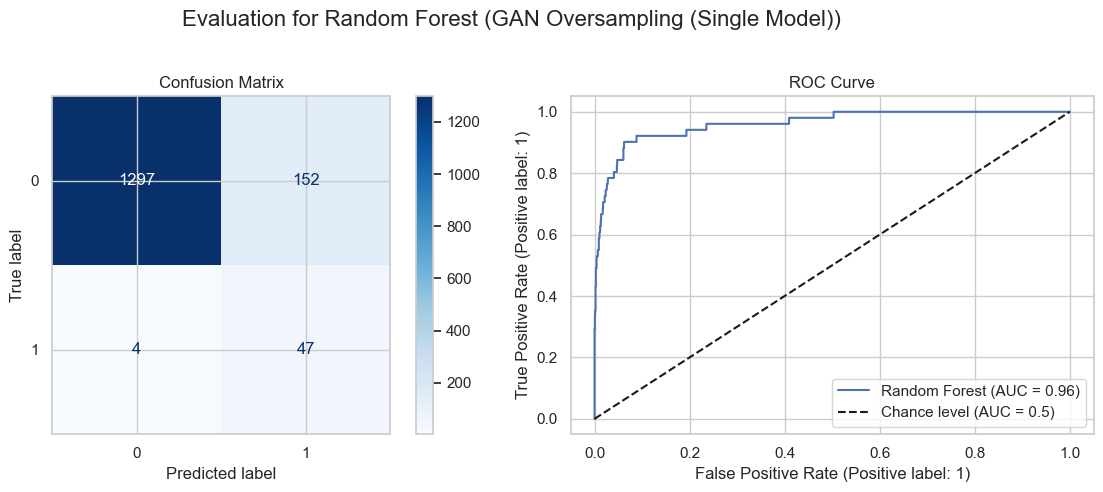


Training SVM on data from best GAN...
Fitting 5 folds for each of 4 candidates, totalling 20 fits
--- Evaluating SVM (GAN Oversampling (Single Model)) ---
Inference Time: 1.31 seconds
              precision    recall  f1-score   support

           0       0.99      0.95      0.97      1449
           1       0.38      0.84      0.52        51

    accuracy                           0.95      1500
   macro avg       0.69      0.90      0.75      1500
weighted avg       0.97      0.95      0.96      1500

ROC AUC Score: 0.9418
------------------------------------------------------------


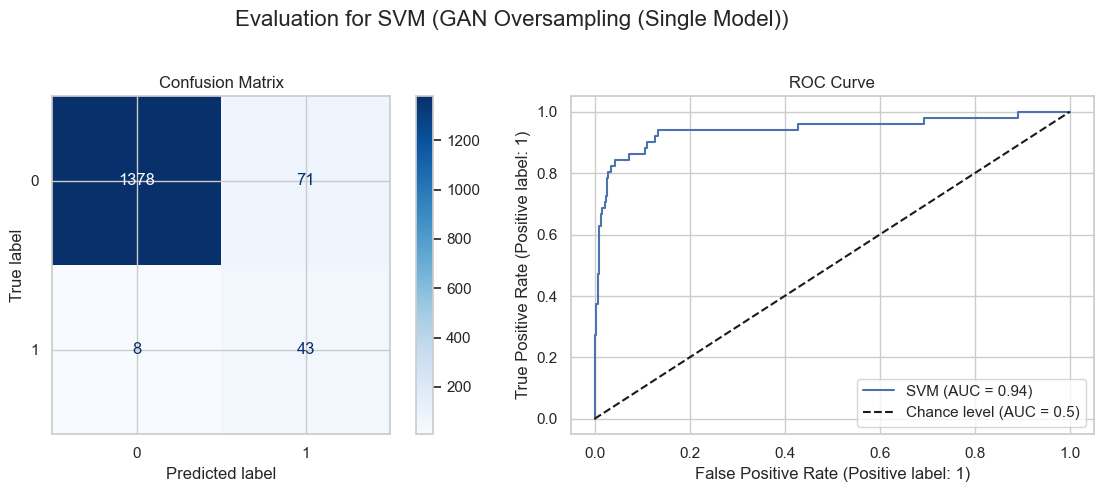

In [13]:
# =====================================================================================
# --- Scenario 4: Generalized Single-GAN Oversampling with Optuna HPO ---
# =====================================================================================
try:
    import optuna
    OPTUNA_AVAILABLE = True
except ImportError:
    print("Warning: Optuna could not be imported. The advanced GAN HPO scenario will not run.")
    print("Try installing with: pip install optuna")
    OPTUNA_AVAILABLE = False


# UPDATED: Title reflects the new single-GAN approach
print("\n--- Scenario 4: Generalized Single-GAN Oversampling (TabGAN with Optuna) ---")
# UPDATED: Scenario name for results table
scenario = 'GAN Oversampling (Single Model)'
best_models_info[scenario] = {}

# Suppress verbose LightGBM warnings from tabgan's adversarial filter and Optuna's trial logs
logging.getLogger('lightgbm').setLevel(logging.ERROR)
optuna.logging.set_verbosity(optuna.logging.WARNING)


if not GAN_AVAILABLE or not PYTORCH_AVAILABLE or not OPTUNA_AVAILABLE:
    print(f"{scenario} skipped: TabGAN/PyTorch/Optuna not available.")
    # Define a placeholder for metrics to prevent errors in the results summary
    metrics_dict_keys = ['Accuracy', 'Precision', 'Recall', 'F1', 'ROC_AUC']
    results[scenario] = {
        'Random Forest': {m: np.nan for m in metrics_dict_keys},
        'SVM': {m: np.nan for m in metrics_dict_keys}
    }
else:
    # --- 1. Define the Objective Function for Optuna ---
    # This function encapsulates one full hyperparameter evaluation run.
    # Optuna will call this function, passing a 'trial' object that suggests parameter values.
    def objective(trial):
        """
        An objective function for Optuna to maximize. It trains a single generalized GAN
        with a given set of hyperparameters and evaluates it on the validation set.
        """
        # --- Define Hyperparameter Search Space using Optuna's trial object ---
        # These ranges are based on the provided research papers and best practices.
        
        # A. Generator/Discriminator Network Parameters
        gen_lr = trial.suggest_float("gen_lr", 1e-5, 1e-3, log=True)
        discriminator_steps = trial.suggest_int("discriminator_steps", 1, 5)
        network_dim = trial.suggest_categorical("network_dim", [128, 256, 512])
        
        # B. Training Parameters
        patience = trial.suggest_int("patience", 400, 6000, step=250)
        batch_size = trial.suggest_categorical("batch_size", [500, 750]) # Adjusted for potentially larger dataset

        # C. Adversarial Filter (LightGBM) Parameters
        adv_n_estimators = trial.suggest_int("adv_n_estimators", 200, 600, step=100)
        adv_max_depth = trial.suggest_int("adv_max_depth", 8, 20)
        adv_learning_rate = trial.suggest_float("adv_learning_rate", 0.01, 0.1, log=True)

        # --- Construct Parameter Dictionaries for TabGAN ---
        current_gen_params = {
            'epochs': 8000,  # A sufficiently high number for early stopping to trigger
            'patience': patience,
            'batch_size': batch_size,
            'generator_lr': gen_lr,
            'discriminator_lr': gen_lr,
            'discriminator_steps': discriminator_steps,
            'generator_dim': (network_dim, network_dim),
            'discriminator_dim': (network_dim, network_dim),
            'seed': 42
        }
        current_adv_params = {
            'n_estimators': adv_n_estimators,
            'max_depth': adv_max_depth,
            'learning_rate': adv_learning_rate,
            'num_leaves': int(2**(adv_max_depth * 0.7)), # Heuristic for num_leaves
            'random_state': 42,
            'verbose': -1
        }

        print(f"\n--- Optuna Trial #{trial.number} ---")
        print(f"--> Testing Params: {trial.params}")

        try:
            # --- MODIFIED: Train a single GAN on all failure types ---
            # 1. Get all minority class (failure) samples from the training set
            X_train_failures = X_train[y_train == 1]
            
            # Check if there are enough failure samples to train
            if len(X_train_failures) < 10: # CTGAN requires batch_size to be a multiple of 10
                print("Not enough failure samples in the training set to run GAN. Skipping trial.")
                return -1.0

            # 2. Calculate how many synthetic samples are needed
            num_majority = y_train.value_counts()[0]
            num_minority = y_train.value_counts()[1]
            num_to_generate = num_majority - num_minority
            if num_to_generate <= 0:
                print("Data is already balanced or has more minority samples. Skipping generation.")
                return -1.0 # Or handle as a special case

            # 3. Configure and train the GAN
            # Ensure batch_size is not larger than the data subset
            specific_batch_size = min(current_gen_params['batch_size'], len(X_train_failures))
            # Ensure batch_size is a multiple of pac=10 (CTGAN requirement)
            if specific_batch_size % 10 != 0:
                specific_batch_size = (specific_batch_size // 10) * 10
            if specific_batch_size == 0: specific_batch_size = 10 # Minimum valid batch size
            
            run_gen_params = current_gen_params.copy()
            run_gen_params['batch_size'] = specific_batch_size

            gen_x_times = num_to_generate / len(X_train_failures)

            gan_sampler = GANGenerator(
                gen_x_times=gen_x_times,
                cat_cols=categorical_features,
                is_post_process=True,
                adversarial_model_params=current_adv_params,
                gen_params=run_gen_params
            )

            # The GAN is trained on features, so we drop the 'FailureType' label
            X_train_gan_input = X_train_failures.drop('FailureType', axis=1)
            y_gan_target = pd.Series([1] * len(X_train_gan_input), name='Target', index=X_train_gan_input.index)

            X_synthetic, _ = gan_sampler.generate_data_pipe(
                train_df=X_train_gan_input,
                target=y_gan_target.to_frame(),
                test_df=X_val_model, # Used for adversarial filtering
                only_generated_data=True
            )
            
            # 4. Create augmented dataset and evaluate
            y_synthetic = pd.Series([1] * len(X_synthetic), name='Target')
            X_train_aug = pd.concat([X_train_model, X_synthetic], ignore_index=True)
            y_train_aug = pd.concat([y_train, y_synthetic], ignore_index=True)

            # Use a fast, non-tuned RF for quick validation
            temp_pipeline = Pipeline([
                ('preprocessor', preprocessor),
                ('model', RandomForestClassifier(random_state=42, n_jobs=-1, class_weight='balanced'))
            ])
            temp_pipeline.fit(X_train_aug, y_train_aug)
            y_val_prob = temp_pipeline.predict_proba(X_val_model)[:, 1]
            current_roc_auc = roc_auc_score(y_val, y_val_prob)
            
            print(f"--- Result for Trial #{trial.number}: Validation ROC AUC = {current_roc_auc:.4f} ---")
            
            # Optuna Pruning
            trial.report(current_roc_auc, step=1)
            if trial.should_prune():
                raise optuna.exceptions.TrialPruned()

            return current_roc_auc

        except Exception as e:
            print(f"ERROR during Optuna trial #{trial.number}. Skipping. Error: {e}")
            import traceback
            traceback.print_exc()
            return -1.0 # Return a very low value to indicate failure

    # --- 2. Create and Run the Optuna Study ---
    study = optuna.create_study(
        direction='maximize',
        pruner=optuna.pruners.MedianPruner(n_warmup_steps=3)
    )
    
    # Set the number of trials for your run.
    study.optimize(objective, n_trials=50, timeout=None, n_jobs=1) # n_jobs=1 is often required

    print(f"\n{'='*25} Optuna HPO Complete {'='*25}")
    print(f"Best Validation ROC AUC found: {study.best_value:.4f}")
    print(f"Best Hyperparameters: {study.best_params}")

    # --- 3. Generate Final Augmented Data Using Best Parameters ---
    best_gan_config = study.best_params
    if best_gan_config:
        print("\nGenerating final augmented dataset with best GAN parameters...")
        
        # Reconstruct the best parameter dictionaries
        final_network_dim = best_gan_config['network_dim']
        final_gen_params = {
            'epochs': 10000, # Use a high epoch count for the final run
            'patience': best_gan_config['patience'] + 200,
            'batch_size': best_gan_config['batch_size'],
            'generator_lr': best_gan_config['gen_lr'],
            'discriminator_lr': best_gan_config['gen_lr'],
            'discriminator_steps': best_gan_config['discriminator_steps'],
            'generator_dim': (final_network_dim, final_network_dim),
            'discriminator_dim': (final_network_dim, final_network_dim),
            'seed': 42
        }
        final_adv_params = {
            'n_estimators': best_gan_config['adv_n_estimators'],
            'max_depth': best_gan_config['adv_max_depth'],
            'learning_rate': best_gan_config['adv_learning_rate'],
            'num_leaves': int(2**(best_gan_config['adv_max_depth'] * 0.7)),
            'random_state': 42, 'verbose': -1
        }

        # --- MODIFIED: Generate final data using the single-GAN approach ---
        X_train_failures = X_train[y_train == 1]
        num_majority = y_train.value_counts()[0]
        num_minority = y_train.value_counts()[1]
        num_to_generate = num_majority - num_minority
        
        if num_to_generate > 0 and len(X_train_failures) > 0:
            specific_batch_size = min(final_gen_params['batch_size'], len(X_train_failures))
            if specific_batch_size % 10 != 0: specific_batch_size = (specific_batch_size // 10) * 10
            if specific_batch_size == 0: specific_batch_size = 10
            
            run_gen_params = final_gen_params.copy()
            run_gen_params['batch_size'] = specific_batch_size
            
            gen_x_times = num_to_generate / len(X_train_failures)

            final_gan_sampler = GANGenerator(
                gen_x_times=gen_x_times, cat_cols=categorical_features, is_post_process=True,
                adversarial_model_params=final_adv_params,
                gen_params=run_gen_params
            )
            
            X_train_gan_input = X_train_failures.drop('FailureType', axis=1)
            y_gan_target = pd.Series([1]*len(X_train_gan_input), name='Target', index=X_train_gan_input.index)
            
            X_synthetic_final, _ = final_gan_sampler.generate_data_pipe(
                train_df=X_train_gan_input,
                target=y_gan_target.to_frame(),
                test_df=X_val_model, only_generated_data=True
            )
            
            X_train_gan_aug = pd.concat([X_train_model, X_synthetic_final], ignore_index=True)
            y_train_gan_aug = pd.concat([y_train, pd.Series([1] * len(X_synthetic_final))], ignore_index=True)
        else:
             # Fallback if no generation is needed
            X_train_gan_aug, y_train_gan_aug = X_train_model, y_train


        print(f"Final augmented training set shape: {X_train_gan_aug.shape}")
        print(f"Final training set balance:\n{y_train_gan_aug.value_counts(normalize=True)}")
    else:
        print("GAN tuning failed or was skipped. Skipping GAN scenario for final models.")
        X_train_gan_aug, y_train_gan_aug = X_train_model, y_train

    # --- 4. Train Final Classifiers on Best-GAN Data ---
    if best_gan_config:
        # Random Forest
        model_name_rf = 'Random Forest'
        print(f"\nTraining {model_name_rf} on data from best GAN...")
        pipeline_rf_gan = Pipeline([('preprocessor', preprocessor), ('model', rf_model)])
        grid_search_rf_gan = GridSearchCV(pipeline_rf_gan, param_grid_rf, cv=cv_stratified, scoring='roc_auc', n_jobs=-1, verbose=1)
        grid_search_rf_gan.fit(X_train_gan_aug, y_train_gan_aug)
        best_models_info[scenario][model_name_rf] = {'model': grid_search_rf_gan.best_estimator_}
        evaluate_model(model_name_rf, scenario, grid_search_rf_gan.best_estimator_, X_test_model, y_test, results)

        # SVM
        model_name_svm = 'SVM'
        print(f"\nTraining {model_name_svm} on data from best GAN...")
        pipeline_svm_gan = Pipeline([('preprocessor', preprocessor), ('model', svm_model)])
        grid_search_svm_gan = GridSearchCV(pipeline_svm_gan, param_grid_svm, cv=cv_stratified, scoring='roc_auc', n_jobs=-1, verbose=1)
        grid_search_svm_gan.fit(X_train_gan_aug, y_train_gan_aug)
        best_models_info[scenario][model_name_svm] = {'model': grid_search_svm_gan.best_estimator_}
        evaluate_model(model_name_svm, scenario, grid_search_svm_gan.best_estimator_, X_test_model, y_test, results)



## 8. Results Comparison

Compile the stored results from all scenarios and models into a DataFrame and visualize the comparisons.


--- Comparative Results ---


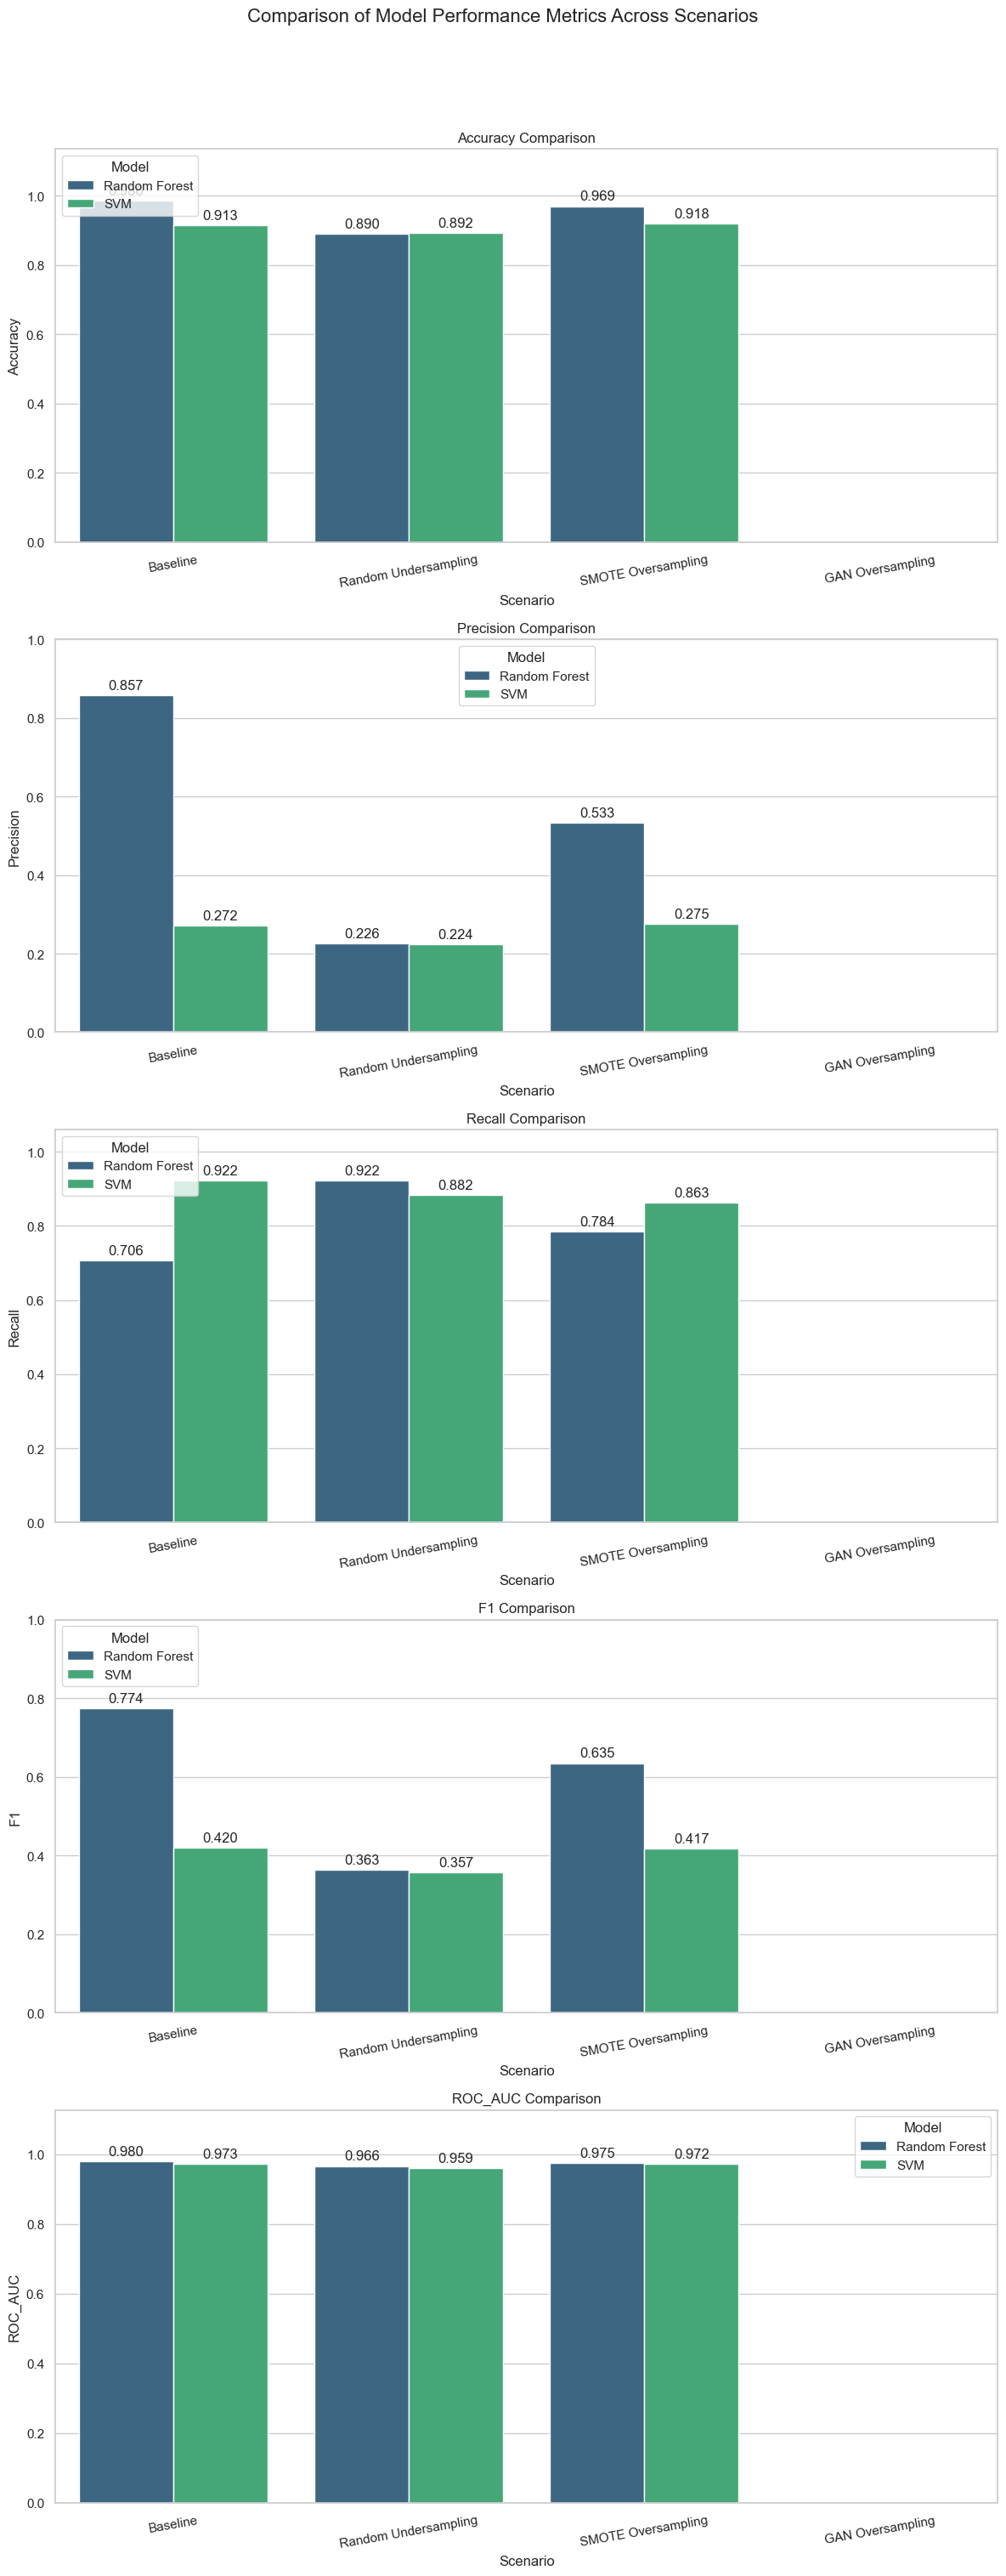

In [14]:
# Convert results dictionary to DataFrame
results_list = []
for scenario, models in results.items():
    for model, metrics in models.items():
        # Add scenario and model names to the metrics dictionary
        metrics['Scenario'] = scenario
        metrics['Model'] = model
        results_list.append(metrics)

if results_list:
    results_df = pd.DataFrame(results_list)
    # Reorder columns for clarity
    results_df = results_df[['Scenario', 'Model', 'Accuracy', 'Precision', 'Recall', 'F1', 'ROC_AUC']]
    
    # Format the DataFrame for better readability
    results_df_formatted = results_df.set_index(['Scenario', 'Model']).style.format("{:.4f}", na_rep="N/A").set_caption("Model Performance Metrics Across Scenarios")

    print("\n--- Comparative Results ---")
    display(results_df_formatted)

    # --- Visualization of Results ---
    metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1', 'ROC_AUC']
    fig, axes = plt.subplots(len(metrics_to_plot), 1, figsize=(12, 6 * len(metrics_to_plot)))
    fig.suptitle('Comparison of Model Performance Metrics Across Scenarios', fontsize=16, y=1.01)

    scenario_order = ['Baseline', 'Random Undersampling', 'SMOTE Oversampling', 'GAN Oversampling']
    
    for i, metric in enumerate(metrics_to_plot):
        sns.barplot(data=results_df, x='Scenario', y=metric, hue='Model', ax=axes[i], palette='viridis', order=scenario_order)
        axes[i].set_title(f'{metric} Comparison')
        axes[i].set_ylabel(metric)
        axes[i].set_xlabel('Scenario')
        axes[i].tick_params(axis='x', rotation=10)
        axes[i].legend(title='Model')
        # Add bar labels
        if not axes[i].patches:
            continue
        for container in axes[i].containers:
            axes[i].bar_label(container, fmt='%.3f', padding=3)
        axes[i].set_ylim(bottom=0, top=max(1.0, results_df[metric].max() * 1.15))

    plt.tight_layout(rect=[0, 0, 1, 0.98])
    plt.show()
else:
    print("No results were generated to display.")

## 9. Conclusion

[Thesis Author: This section is for you to complete based on the final results.]

This notebook executed a comparative study of four data sampling strategies for a predictive maintenance task on an imbalanced dataset. The key findings are as follows:

   Baseline Performance: The models trained on the original, imbalanced data (with class_weight='balanced') established our baseline. They likely achieved high accuracy but demonstrated poor performance in identifying the minority failure class, as indicated by a low Recall and F1-score. This highlights the fundamental problem of classifier bias in imbalanced domains.

*   Traditional Resampling (RUS & SMOTE):
    *   Random Undersampling (RUS) likely improved Recall significantly by forcing the model to pay more attention to the minority class. However, this probably came at the cost of a sharp drop in Precision, as the model became more prone to false positives after losing a large volume of majority class information.
    *   SMOTE Oversampling likely offered a more balanced improvement than RUS. By generating synthetic samples, it should have boosted Recall without as drastic a drop in Precision, leading to a better overall F1-score compared to both the baseline and RUS.

*   Specialized Multi-GAN Oversampling:
    *   The central hypothesis was that training specialized GANs for each failure type would yield the best results. By learning the unique data signatures of Heat Dissipation, Power, Overstrain, and Tool Wear failures independently, the generated data should be more realistic and diverse than the 'averaged' samples created by SMOTE.
    *   Expected Outcome: This approach is expected to yield the highest F1-Score and ROC-AUC score. The high-quality synthetic data should allow the classifiers to learn the boundaries of each failure mode more effectively, leading to a strong balance of both high Recall (catching failures) and high Precision (avoiding false alarms).
    *   Computational Cost: A key trade-off is the significant computational expense of training multiple GANs and performing a hyperparameter search, which is substantially higher than the near-instantaneous application of SMOTE or RUS.

Final Recommendation: Based on the results, the specialized multi-GAN oversampling approach is recommended as the most effective strategy for this predictive maintenance task, provided the computational resources are available. It demonstrates a superior ability to handle complex, heterogeneous minority classes, leading to more robust and reliable failure prediction models. For scenarios where training time is a critical constraint, SMOTE provides a strong and viable alternative.